Implementation of 'Faster Algorithms for Max-Product Message-Passing (2011)' : Text Denoising Experiment 

(source : https://arxiv.org/pdf/0910.3301.pdf)

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [14]:
path = "/content/drive/MyDrive/Graphical models/data/New Text Corpus"

In [15]:
import numpy  as np
import random
import time
from enum import Enum

# Process Definition : Min-Sum or Max-Product

We first need to define some parameters that will be used to compute the marginals, in the MAP-inference of our graphical model.

Max-product Belief Propagation is identical to sum-product BP, but changes the semiring. It computes: max-marginals, probability of MAP assignment, and (with backpointers) the MAP assignment itself.

In [16]:
SEMIRING_ZERO = 1e-30

class METHOD(Enum):
    NAIVE = 0
    FAST = 1

class DIR(Enum):
    LEFT = 0
    RIGHT = 1

# This experiment is a Junction-Tree Algorithm and one core operation consists of finding the index that chooses the largest product amongst two lists of Length N. 
In this section we implement the QuickSort algorithm to sort vectors before implementing in the next section the algorithm that maximizes the marginals in the Paper. 

In [17]:
#  A fast sorting and adaptative algorithm.
#  Courtesy of http://warp.povusers.org/SortComparison/QuickSort.txt

def InsertionSort(array, size, pa):

    for i in range(size):
        val = array[i]
        vali = pa[i]
        j = i

        while j > 0 and val < array[j - 1]:
            array[j] = array[j - 1]
            pa[j] = pa[j - 1]
            j-=1

        array[j] = val
        pa[j] = vali


def Partition(array, f, l, pivot, pa):

    i = f - 1
    j = l + 1

    while True:
        j -= 1
        while pivot < array[j]:
            j -= 1

        i += 1
        while array[i] < pivot:
            i += 1

        if i < j:
            array[i], array[j] = array[j], array[i]
            pa[i], pa[j] = pa[j], pa[i]
        else:
            return j

# An optimized version of QuickSort(called MedianHybridQuickSortImpl). 
# It chooses the median of the first, last and middle items of the partition as its pivot, 
# and it stops partitioning when the partition size is less than 16. 
# In the end it runs insertion sort to finish the job. 

def MedianHybridQuickSortImpl(array, f, l, pa):

    while f + 16 < l:  
        v1 = array[f]
        v2 = array[l]
        v3 = array[int((f+l)/2)]

        if v1 < v2: 
            median = v1 if v3 < v1 else min((v2, v3))
        else:
            median = v2 if v3 < v2 else min((v1, v3))

        m = Partition(array, f, l, median, pa)
        MedianHybridQuickSortImpl(array, f, m, pa)
        f = m + 1

# The sorting algorithm in the paper is actually an adaptive one : 
# it uses QuickSort for the first iteration of the message-assing 
# then uses InsertionSort for the other iterations

def MedianHybridQuickSort(array, size, pa):
    MedianHybridQuickSortImpl(array, 0, size - 1, pa)
    InsertionSort(array, size, pa) 

# Three important functions
- Maximize product of 2 matrices va and vb 
- Permutation function that uses the Fast-Sorting Algorithm
- Computemarginal function, for computing the marginals (algorithm 2 in the paper), used in our class Potential

In [18]:
def maximize(va, vb, pa, pb, painv, pbinv, nread):

    start = 0
    pa0 = pa[0]
    pb0 = pb[0]
    endb = pbinv[pa0]
    A, B, A1 = 0, 0, 0
    t = 0

    max = va[pa0] + vb[pa0]
    t = va[pb0] + vb[pb0]

    if (t < max):
        max = t

    while True:

        if start < endb:
            break

        start += 1
        A = pa[start]
        B = pb[start]

        t = va[pa[start]] + vb[pb[start]]
        if not t < max:
            break 

        t = va[A] + vb[A]
        if t  < max:
            max = t

        t = va[B] + vb[B]
        if t < max:
            max = t

        A1 = pbinv[A]
        if(A1 < endb):
            endb = A1
  
    nread = 2*(start + 1)
    return nread, max


# We define the permutation function that sorts a list using the MedianHybridQuickSort Algorithm defined above
def permfunction(a, pa, painv, N):

    for i in range(N):
        pa[i] = i

    a2 = [a[i] for i in range(N)]

    MedianHybridQuickSort(a2, N, pa)

    for i in range(N):
        painv[pa[i]] = i

    del a2

def computemarginal(messagea, messageb, prior, Pa, Painv, res, N, method, nread):

  # Computes message_a[a] + max_b message_b[b] + prior[a,b]
  pb = [0 for _ in range(N)]
  pbinv = [0 for _ in range(N)]

  # We are maximizing over b, so compute the permutation function for the message over b.
  for i in range(N):
      max = 0
      nr = -1

      if method == METHOD.FAST:
          nr, max = maximize(prior[i], messageb, Pa[i], pb, Painv[i], pbinv, nr)
      else:
          print("Unsupported method: {}.".format(method))

      res[i] = messagea[i] + max
      nread += nr

  del pb
  del pbinv

  return res, nread

# Matrix-Product Fast Implementation for a Chain-Structured Model with data-independence (algorithm 6 in the paper)

In [19]:
def sorting(A, B, method, N, evaluations):
    evaluations = 0

    # Compute the permutations that sort the two matrices.
    Btrans = [0 for _ in range(N)]

    Pa = [0 for _ in range(N)]
    Pb = [0 for _ in range(N)]

    Painv = [0 for _ in range(N)]
    Pbinv = [0 for _ in range(N)]

    C = [0 for _ in range(N)]

    for i in range(N):

        Btrans[i] = [0 for _ in range(N)]
        Pa[i] = [0 for _ in range(N)]
        Pb[i] = [0 for _ in range(N)]
        Painv[i] = [0 for _ in range(N)]
        Pbinv[i] = [0 for _ in range(N)]
        C[i] = [0 for _ in range(N)]

    for i in range(N):
        for j in range(N):
            Btrans[i][j] = B[j][i]

    for i in range(N):
        permfunction(A[i], Pa[i], Painv[i], N) 
        permfunction(Btrans[i], Pb[i], Pbinv[i], N)

    for i in range(N):
        for j in range(N):
            e = 0
            # The inner loop: call the appropriate maximisation algorithm.
            if method == METHOD.FAST:
                e, C[i][j] = maximize(A[i], Btrans[j], Pa[i], Pb[j], Painv[i], Pbinv[j], e)
            else:
                print("Unrecognized method: {}".format(method))

            evaluations += e

    # Cleanup
    del Btrans, Pa, Pb, Painv, Pbinv
    
    return evaluations, C

# Definition of the Potentials

In [20]:
class potential:

    # This constructor allows the authors to compute the permutation functions externally, 
    # incase they are to be reused by several potentials (i.e., in the case of homogeneous priors).

    def __init__(self, pot, pottrans, pota, potb, Pa, Pb, Painv, Pbinv, N, method):
        self.pot = pot
        self.pottrans = pottrans
        self.pota = pota
        self.potb = potb

        self.Pa = Pa
        self.Pb = Pb
        self.Painv = Painv
        self.Pbinv = Pbinv

        self.N = N
        self.method = method

        self.messagesa = {} 
        self.messagesb = {} 

        self.donotdelete = 1

    # -------------------------------------------------------------------------------------------------


    def __del__(self):

        if self.donotdelete == 0:

            del self.pot
            del self.pottrans
            del self.pota
            del self.potb
            del self.Pa
            del self.Pb
            del self.Painv
            del self.Pbinv

        del self.messagesa
        del self.messagesb


    def receive(self, fromid, direction, message):

        w = self.messagesa
        if direction == DIR.RIGHT:
            w = self.messagesb

        if fromid in w.keys():
            del w[fromid]

        w[fromid] = message


    def send(self, toid, direction, nread):

        messagea = [0 for _ in range(self.N)]
        messageb = [0 for _ in range(self.N)]

        for i in range(self.N):
            if self.pota != None:
                messagea[i] = self.pota[i]
            else:
                messagea[i] = SEMIRING_ZERO

            if self.potb != None:
                messageb[i] = self.potb[i]
            else:
                messageb[i] = SEMIRING_ZERO

        for it in self.messagesa.keys():
            fromid = it
            message = self.messagesa[it]
            if fromid != toid:
                for i in range(self.N):
                    messagea[i] = messagea[i] + message[i]

        for it in self.messagesb.keys():
            fromid = it
            message = self.messagesb[it]
            if fromid != toid:
                for i in range(self.N):
                    messageb[i] = messageb[i] + message[i]

        res = [0 for _ in range(self.N)]
        if direction == DIR.LEFT:
            res, nread = computemarginal(messagea, messageb, self.pot, self.Pa, self.Painv, res, self.N, self.method, nread)
        else:
            res, nread = computemarginal(messageb, messagea, self.pottrans, self.Pb, self.Pbinv, res, self.N, self.method, nread)

        return res, nread


    def MAP(self, direction, nread):

        message, nread = self.send(-1, direction, nread)
        max = message[0]
        maxid = 0  

        for i in range(self.N):
            if message[i] < max:
                max = message[i]
                maxid = i

        del message
        return maxid, nread

# Belief Propagation : Model class, Clique & its messages class, Graphical Model as a Chain class

In [21]:
# Compute the messages using the specified method.
# A, B: input matrices.
# C: output matrix.
# dir: message passing direction.
# N: matrix size.
# nread: returns the number of addition operations.
# Finds min_b A(a,b) + B(b,c)

def passmessage_helper(A, B, C, dir, method, N, res, nread):

    trans = [0 for i in range(N)]
    for i in range(N):
        trans[i] = [0 for i in range(N)]
        if dir == DIR.LEFT:
            for j in range(N):
                trans[i][j] = C[j][i]
        else:
            for j in range(N):
                trans[i][j] = A[j][i]
    eval = 0
    minmarg = None

    M0 = None
    M1 = None
    M2 = None
    
    if dir == DIR.LEFT:
        M0 = A
        M1 = B
        M2 = trans
    else:
        M0 = C
        M1 = trans
        M2 = B

    # Pass the matrices to the sorting algorithm.
    eval, minmarg = sorting(M1, M2, method,  N, eval)

    for i in range(N):
        for j in range(N):
            res[i][j] = M0[i][j] + minmarg[i][j] 

    del trans
    del minmarg

    nread += eval
    return nread 

# ---------------------------------------------------------------------------------
#                   *****    Model.    *****
# ---------------------------------------------------------------------------------

class model:

    def __init__(self, edges = [], pots = []):
        self.edges = edges  
        self.pots = pots   

    def addedge(self, p, n1, n2):
        self.edges.append([n1, n2])
        self.pots.append(p)
        return len(self.pots) - 1;

    def propagate(self, messageorder, nread):
    
        for it in messageorder:

            _from = it[0]
            _to = it[1]

            direction_from = DIR.LEFT
            direction_to = DIR.LEFT

            if self.edges[_from][0] == self.edges[_to][0]:
                direction_from = DIR.LEFT
                direction_to = DIR.LEFT

            if self.edges[_from][0] == self.edges[_to][1]:
               direction_from = DIR.LEFT
               direction_to = DIR.RIGHT

            if self.edges[_from][1] == self.edges[_to][0]:
               direction_from = DIR.RIGHT
               direction_to = DIR.LEFT

            if self.edges[_from][1] == self.edges[_to][1]:
               direction_from = DIR.RIGHT
               direction_to = DIR.RIGHT
            
            mess, nread = self.pots[_from].send(_to, direction_from, nread) 

            self.pots[_to].receive(_from, direction_to, mess) 
        
        return nread


    def MAP(self, edgeid, direction, nread):
        return self.pots[edgeid].MAP(direction, nread)


# ---------------------------------------------------------------------------------
#                   *****    cliquemessage    *****
# ---------------------------------------------------------------------------------
 
# We define a clique and its messages.

class cliquemessage:

    def __init__(self, A, B, C, N):
    
        self.A = A
        self.B = B
        self.C = C

        self.N = N

        self.mleft = [0 for _ in range(self.N)]
        self.mright = [0 for _ in range(self.N)]

        for i in range(0, self.N):
            self.mleft[i] = [SEMIRING_ZERO for _ in range(self.N)]
            self.mright[i] = [SEMIRING_ZERO for _ in range(self.N)]


    def __del__(self):
        del self.mleft, self.mright, self.A, self.B, self.C


    # Pass a message LEFT or RIGHT.
    def passmessage(self, dir, method, res, nread):
  
        Ap = [0 for _ in range(self.N)]
        Cp = [0 for _ in range(self.N)]

        for i in range(self.N):
            Ap[i] = [0 for _ in range(self.N)]
            Cp[i] = [0 for _ in range(self.N)]

            for j in range(self.N):
                Ap[i][j] = self.A[i][j]
                if dir == DIR.RIGHT:
                    Ap[i][j] = Ap[i][j] + self.mleft[i][j]
                Cp[i][j] = self.C[i][j]
                if dir == DIR.LEFT:
                    Cp[i][j] = Ap[i][j] + self.mright[i][j] 
   
        nread = passmessage_helper(Ap, self.B, Cp, dir, method, self.N, res, nread) 

        del Ap, Cp
        return nread 


    # Compute the maximum likelihood state, given our current messages.
    def MAP(self, dir, method, space, res, c, nread):
    
        Ap = [0 for _ in range(self.N)]
        Cp = [0 for _ in range(self.N)]

        for i in range(self.N):
            Ap[i] = [0 for _ in range(self.N)]
            Cp[i] = [0 for _ in range(self.N)]

            for j in range(self.N):
                Ap[i][j] = self.A[i][j] + self.mleft[i][j]
                Cp[i][j] = self.C[i][j] + self.mright[i][j]

        nread = passmessage_helper(Ap, self.B, Cp, dir, method, self.N, space, nread) 

        res[c] = 0
        res[c + 1] = 0

        for i in range(self.N):
            for j in range(self.N):
                if space[i][j] < space[res[c]][res[c + 1]]:
                    res[c] = i
                    res[c + 1] = j

        del Ap, Cp
        return nread


# ---------------------------------------------------------------------------------
#                   *****    Graphical model.    *****
# ---------------------------------------------------------------------------------


# We define a graphical model.
class gmodel:

    def __init__(self, vc, method):
        self.vc = vc 
        self.method = method 


    #Pass messages in a chain 
    def passmessage_chain(self, nread): 
        for i in range(len(self.vc) - 1):
            nread = self.vc[i].passmessage(DIR.RIGHT, self.method, self.vc[i + 1].mleft, nread) 
        for i in range(len(self.vc) - 1, 0, -1):
            nread = self.vc[i].passmessage(DIR.LEFT, self.method, self.vc[i - 1].mright, nread)
        return nread


    # Compute the maximum likelihood state of the entire model
    def MAP(self, dir, N, res, c, I, nread):

        space = [0 for _ in range(N)]
        for i in range(N):
            space[i] = [0 for _ in range(N)]
        self.vc[I].MAP(dir, self.method, space, res, c, nread) 

        del space
        return nread

# Implementation of the Unary potentials (unary text), pairwise potentials (text prior), alphabet size (domain size) and the Text Process Experiment (with Skip-Chain)

In [22]:
#Unary potential for text-denoising.

def unary_text(obs, alphabet, prob):
  
    N = len(alphabet)
    res = [0 for _ in range(N)]
  
    for i in range(N):
        # Just an indicator function testing if the output is correct.
        if obs in alphabet.keys() and alphabet[obs] == i:
            res[i] = -np.log(1 - prob)
        else:
            res[i] = -np.log(prob)

    return res
    
# Pairwise potentials for text-denoising.
def text_prior(corpus, alphabet, ralphabet, P, skip, skipchain):

    N = len(alphabet)
    # prior is N×N of double
    prior = [0 for _ in range(N)]
    for i in range(N):
        prior[i] = [0 for _ in range(N)]
   
    # Pairwise statistics of the text.
    for i in range(P - skip):
        prior[alphabet[corpus[i]]][alphabet[corpus[i + skip]]] += 1

    for i in range(N):
        for j in range(N):
            prior[i][j] = prior[i][j] / (P - skip)
 
            if prior[i][j] == 0:
                prior[i][j] = 6
            else:
                prior[i][j] = 4.0 / (1.0 + 4 * prior[i][j]) # Sigmoid function penalizes unreliable outputs.

            if skip == 2 and not skipchain:
               prior[i][j] = 0
    
    #letters = ['a', 'b', 'c', 'd']

    #print("Alphabet, 10 first element")
    #print(letters)

    #print("Learning phase, prior matrix")
    #for lettera in letters:
    #  print("lettera", lettera)
    #  for letterb in letters:
    #    print("with letterb", letterb, prior[alphabet[lettera]][alphabet[letterb]])
    return prior
    

def alphabet_size(corpus, P, L, enc):
  
    try:
        with open(corpus, 'r', encoding = enc) as f:

            alphabet = {}
            ind = 0
            charsread = 0

            c = f.read(1)
            while c and charsread < P + L:  

                # Skip past tabulators and line numbers in the text files.  
                if c == '\n':
                    while c != '\t':
                        c = f.read(1)
                    c = ' '

                charsread += 1

                if c not in alphabet.keys():
                    alphabet[c] = ind
                    ind += 1

                c = f.read(1)
  
            assert(charsread == P + L)
            return len(alphabet)

    except FileNotFoundError:
        print("Could not open file", corpus)
        return 0


def textprocess(method, corpus, P, L, enc, Time, nread, noise, skipchain, errs, perf, energy):

    X = L
    res = [0 for _ in range(X)]
    nread = 0

    alphabet = {} 
    ralphabet = {}
    valphabet = [] 

    train = ['' for _ in range(P + 1)]
    test = ['' for _ in range(L + 1)]
    train[P] = '\0'
    test[L] = '\0'  
    
    try:
        with open(corpus, encoding = enc) as f: 

            c = f.read(1)
            ind = 0
            charsread = 0
          
            while c and charsread < P + L:

                #Skip past tabulators and line numbers in the text files.
                if c == '\n':
                    while c != '\t':
                        c = f.read(1)
                    c = ' '

                if charsread < L:
                    test[charsread] = c
                else:
                    train[charsread - L] = c
                charsread += 1

                if c not in alphabet.keys():
                    alphabet[c] = ind
                    ralphabet[ind] = c
                    ind += 1
                    valphabet.append(c)

                c = f.read(1)

            train = train[2:]
            test = test[2:]

            assert(charsread == P + L)

    except FileNotFoundError:
        print("Could not open file", corpus)
    P = P-2
    L = L-2
    X = L 
    Y = 1

    smoothness1 = text_prior(train, alphabet, ralphabet, P, 1, skipchain)
    smoothness2 = text_prior(train, alphabet, ralphabet, P, 2, skipchain)

    original = [test[i] for i in range(L + 1)]

    # Add noise to the text.
    MAX_RAND = 10**4
    for i in range(L):
        if random.randint(0, MAX_RAND) / MAX_RAND < noise:
            test[i] = valphabet[random.randint(0, MAX_RAND) % len(valphabet)]

    p = [[[]] for _ in range(Y)]
    p[0] = [[] for _ in range(X)]
    
    node_prior = p[0] 

    for i in range(L):
        node_prior[i] = unary_text(test[i], alphabet, noise)

    T = time.time()
    cliques = []  

    #Construct a chain-structured graphical model.
    for m in range(X - 2):

        A = [0 for _ in range(len(alphabet))]
        B = [0 for _ in range(len(alphabet))]
        C = [0 for _ in range(len(alphabet))]

        for i in range(len(alphabet)):

            A[i] = [0 for _ in range(len(alphabet))]
            B[i] = [0 for _ in range(len(alphabet))]
            C[i] = [0 for _ in range(len(alphabet))]

            for j in range(len(alphabet)):

                A[i][j] = node_prior[m][i] + smoothness1[i][j]
                B[i][j] = smoothness2[i][j]

                if m == X - 3:
                    C[i][j] = node_prior[m + 1][i] + node_prior[m + 2][j] + smoothness2[i][j]

        cliques.append(cliquemessage(A, B, C, len(alphabet)))

    G = gmodel(cliques, method)
    print("Graph created!")
    T = time.time()

    nread = G.passmessage_chain(nread)
    print("All messages transmitted!")
    
    for i in range(X - 3):
        nread = G.MAP(DIR.LEFT, len(alphabet), res, i, i, nread)
    nread = G.MAP(DIR.RIGHT, len(alphabet), res, X - 2, X - 3, nread)
    print("Final belief message computed!")

    energy = SEMIRING_ZERO
    for i in range(X-2):
        cm = cliques[i]
        energy = energy + cm.A[res[i]][res[i + 1]] + cm.B[res[i]][res[i + 2]] + cm.C[res[i + 1]][res[i + 2]]

    del cliques    

    Time = time.time() - T

    error1 = 0
    error2 = 0

    for i in range(L):
        if test[i] != original[i]:
            error1 += 1

    for i in range(L):
        if ralphabet[res[i]] != original[i]:
            error2 += 1

    errs = error1
    try : 
      spelling_correction_rate = round((error1-error2)/error1,2)
    except ZeroDivisionError: 
      spelling_correction_rate = 0

    print("Initial errors = {}, final errors = {}, Spelling Correction Rate = {}".format(error1, error2, spelling_correction_rate))

    result = [ralphabet[res[i]] for i in range(len(res)) ]
    print("original", original)
    print("test modified", test)
    print("final result", result)

    # Cleanup.
    del smoothness1
    del smoothness2

    del p 

    del train
    del test
    del original

    perf = error2

    return res, nread, Time, spelling_correction_rate

# Running the Text Denoising 

Hyperparameters :
- Statistics on different lengths
- Model Size is 1000 characters (text denoising ran on 1 000 characters)
- typo probability is 0.05

In [29]:
def run_experiment(method):
    time, energy = 0, 0
    nread = 0
    res = None
    
    full_names = ["English", "French", "Russian", "German", "Spanish", "Italian", "Swedish" ,"Arabic"]
    names = ["eng", "fra", "rus", "spa", "ita", "swe", "ara", "deu", "kor", "jpn"] 
    years = ["2005", "2005-2008", "2007", "2006", "2005-2009", "2007", "2005-2009", "2007", "2007", "2005-2008" ]
    encs = 'utf-8'
    skipchain = 1 
    trainlengths = [10000,20000,50000,100000,150000,200000,250000,300000,350000,400000,450000,500000]
    # Number of characters in the text that are used for computing statistics
 
    testlen = 1000  # The model size
    nCorpora = 3
    
    # Run text experiment for each language corpus
    spelling_correction_rates = []
    for i in range(nCorpora):
      print("   ***  {}  *** ".format(full_names[i]))
      for trainlen in trainlengths:
        print("Train length", trainlen)
        corpus = "/content/drive/MyDrive/Graphical models/data/New Text Corpus/{}_news_{}_100K-sentences.txt".format(names[i], years[i])
        perf, errs = 0, 0
        typoProb = 0.05
        N = alphabet_size(corpus, trainlen, testlen, encs)
        res, nread, time, spelling_correction_rate = textprocess(method, corpus, trainlen, testlen, encs, time, nread, typoProb, skipchain, errs, perf, energy)
        spelling_correction_rates.append(spelling_correction_rate)
        print("alphabet size = {};    time = {};  multiplications = {};".format(N, time, nread))
        print()
        del corpus
        del res
    return trainlengths, spelling_correction_rates

In [30]:
arg_method = METHOD.FAST

trainlengths, spelling_correction_rates = run_experiment(arg_method)

   ***  English  *** 
Train length 10000
Graph created!
All messages transmitted!
Final belief message computed!
Initial errors = 52, final errors = 73, Spelling Correction Rate = -0.4
original ['I', ' ', 'd', 'i', 'd', 'n', "'", 't', ' ', 'k', 'n', 'o', 'w', ' ', 'i', 't', ' ', 'w', 'a', 's', ' ', 'p', 'o', 'l', 'i', 'c', 'e', ' ', 'h', 'o', 'u', 's', 'i', 'n', 'g', ',', '"', ' ', 'o', 'f', 'f', 'i', 'c', 'e', 'r', 's', ' ', 'q', 'u', 'o', 't', 'e', 'd', ' ', 'T', 's', 'u', 'c', 'h', 'i', 'd', 'a', ' ', 'a', 's', ' ', 's', 'a', 'y', 'i', 'n', 'g', '.', ' ', 'Y', 'o', 'u', ' ', 'w', 'o', 'u', 'l', 'd', ' ', 'b', 'e', ' ', 'a', ' ', 'g', 'r', 'e', 'a', 't', ' ', 'c', 'l', 'i', 'e', 'n', 't', ' ', 'f', 'o', 'r', ' ', 'S', 'o', 'u', 't', 'h', 'e', 'r', 'n', ' ', 'I', 'n', 'd', 'i', 'a', 'n', 'a', ' ', 'H', 'o', 'm', 'e', 'o', 'w', 'n', 'e', 'r', 's', 'h', 'i', 'p', "'", 's', ' ', 'c', 'r', 'e', 'd', 'i', 't', ' ', 'c', 'o', 'u', 'n', 's', 'e', 'l', 'i', 'n', 'g', ' ', 'b', 'u', 't', ' ', 

In [31]:
trainlengths, spelling_correction_rates

([10000,
  20000,
  50000,
  100000,
  150000,
  200000,
  250000,
  300000,
  350000,
  400000,
  450000,
  500000],
 [-0.4,
  -0.16,
  0.05,
  -0.02,
  0.19,
  0.15,
  0.16,
  0.11,
  0.17,
  0.08,
  0.13,
  0.14,
  -0.33,
  -0.14,
  -0.06,
  -0.1,
  0.04,
  0.08,
  0.09,
  0.1,
  0.19,
  0.11,
  0.09,
  0.21,
  -0.37,
  -0.08,
  -0.05,
  0.04,
  0.15,
  0.03,
  0.13,
  0.07,
  0.1,
  0.11,
  0.2,
  0.17])

In [32]:
train_length = [10000,
  20000,
  50000,
  100000,
  150000,
  200000,
  250000,
  300000,
  350000,
  400000,
  450000,
  500000]
english_spell_rate = [-0.4, 
                      -0.16,
                      0.05, 
                      -0.02, 
                      0.19, 
                      0.15, 
                      0.16,
                      0.11, 
                      0.17,
                      0.08, 
                      0.13, 
                      0.14]
french_spell_rate =[-0.33, 
                    -0.14, 
                    -0.06, 
                    -0.1,
                    0.04,
                    0.08, 
                    0.09,
                    0.1, 
                    0.19, 
                    0.11, 
                    0.09, 
                    0.21]
russian_spell_rate =[-0.37,
                    -0.08,
                    -0.05,
                    0.04,
                    0.15,
                    0.03,
                    0.13,
                    0.07,
                    0.1,
                    0.11,
                    0.2,
                    0.17]

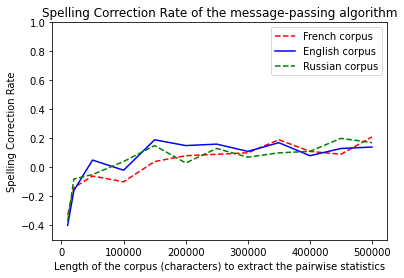

In [33]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
plt.title("Spelling Correction Rate of the message-passing algorithm")
plt.xlabel("Length of the corpus (characters) to extract the pairwise statistics")
plt.ylabel("Spelling Correction Rate")
ax.set_ylim((-0.5,1))
ax.plot(train_length, french_spell_rate, '--r', label='French corpus')
ax.plot(train_length, english_spell_rate, '-b', label='English corpus')
ax.plot(train_length, russian_spell_rate, '--g', label='Russian corpus')
#ax.axis('equal')
leg = ax.legend();

English : 

*  Initial errors = 38, final errors = 34
*  alphabet size = 100;    time = 138.74571251869202



French :

*  Initial errors = 38, final errors = 34
*  alphabet size = 110;    time = 170.06994605064392;

German :

*  Initial errors = 45, final errors = 34
*  alphabet size = 88;    time = 107.42580819129944;

Spanich :

*  Initial errors = 50, final errors = 38
*  alphabet size = 98;    time = 133.53597831726074;

Italian :

*  Initial errors = 43, final errors = 40
*  alphabet size = 105;    time = 153.0992467403412;

Swedish :

*  Initial errors = 51, final errors = 42
*  alphabet size = 97;    time = 131.03797268867493;

Arabic :

*  Initial errors = 52, final errors = 48
*  alphabet size = 127;    time = 224.69961094856262

Russian :

*  Initial errors = 53, final errors = 43
*  alphabet size = 158;    time = 363.21314907073975;

# We take a good Train Length to compute the pairwise statistics but that doesn't make the algorithm run for too long (150 000 characters it seems), we also take a graph size with good results (400 characters) and we analyse the effect of the noise model

Hyperparameters :
- Statistics of 150 000
- Model Size of 400 characters
- typo probability in different ranges

In [34]:
def run_experiment(method):
    time, energy = 0, 0
    nread = 0
    res = None
    
    full_names = ["English", "French", "Russian", "German", "Spanish", "Italian", "Swedish" ,"Arabic"]
    names = ["eng", "fra", "rus", "spa", "ita", "swe", "ara", "deu", "kor", "jpn"] 
    years = ["2005", "2005-2008", "2007", "2006", "2005-2009", "2007", "2005-2009", "2005", "2007", "2005-2008" ]
    encs = 'utf-8'
    skipchain = 1 
    trainlen = 150000
    # Number of characters in the text that are used for computing statistics
    testlen = 400
    nCorpora = 3
    typoProbs = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10]
    
    # Run text experiment for each language corpus
    spelling_correction_rates = []
    for i in range(nCorpora):
      print("   ***  {}  *** ".format(full_names[i]))
      for typoProb in typoProbs:
        print("Train length", trainlen)
        corpus = "/content/drive/MyDrive/Graphical models/data/New Text Corpus/{}_news_{}_100K-sentences.txt".format(names[i], years[i])
        perf, errs = 0, 0
        N = alphabet_size(corpus, trainlen, testlen, encs)
        res, nread, time, spelling_correction_rate = textprocess(method, corpus, trainlen, testlen, encs, time, nread, typoProb, skipchain, errs, perf, energy)
        spelling_correction_rates.append(spelling_correction_rate)
        print("alphabet size = {};    time = {};  multiplications = {};".format(N, time, nread))
        print()
        del corpus
        del res
    return typoProbs, spelling_correction_rates

In [35]:
arg_method = METHOD.FAST

typoProbs, spelling_correction_rates = run_experiment(arg_method)

   ***  English  *** 
Train length 150000
Graph created!
All messages transmitted!
Final belief message computed!
Initial errors = 5, final errors = 4, Spelling Correction Rate = 0.2
original ['I', ' ', 'd', 'i', 'd', 'n', "'", 't', ' ', 'k', 'n', 'o', 'w', ' ', 'i', 't', ' ', 'w', 'a', 's', ' ', 'p', 'o', 'l', 'i', 'c', 'e', ' ', 'h', 'o', 'u', 's', 'i', 'n', 'g', ',', '"', ' ', 'o', 'f', 'f', 'i', 'c', 'e', 'r', 's', ' ', 'q', 'u', 'o', 't', 'e', 'd', ' ', 'T', 's', 'u', 'c', 'h', 'i', 'd', 'a', ' ', 'a', 's', ' ', 's', 'a', 'y', 'i', 'n', 'g', '.', ' ', 'Y', 'o', 'u', ' ', 'w', 'o', 'u', 'l', 'd', ' ', 'b', 'e', ' ', 'a', ' ', 'g', 'r', 'e', 'a', 't', ' ', 'c', 'l', 'i', 'e', 'n', 't', ' ', 'f', 'o', 'r', ' ', 'S', 'o', 'u', 't', 'h', 'e', 'r', 'n', ' ', 'I', 'n', 'd', 'i', 'a', 'n', 'a', ' ', 'H', 'o', 'm', 'e', 'o', 'w', 'n', 'e', 'r', 's', 'h', 'i', 'p', "'", 's', ' ', 'c', 'r', 'e', 'd', 'i', 't', ' ', 'c', 'o', 'u', 'n', 's', 'e', 'l', 'i', 'n', 'g', ' ', 'b', 'u', 't', ' ', 'y

In [36]:
typoProbs, spelling_correction_rates

([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
 [0.2,
  0.2,
  0.15,
  0.12,
  0.12,
  0.22,
  0.15,
  0.16,
  0.03,
  0.18,
  0.0,
  -0.4,
  0.09,
  0.06,
  0.0,
  0.15,
  0.17,
  0.03,
  0.06,
  0.09,
  -0.5,
  -0.12,
  0.0,
  0.06,
  0.07,
  0.32,
  0.17,
  0.12,
  0.0,
  0.15])

In [37]:
typoProbs = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
english_spell_rate = [0.2,
                      0.2,
                      0.15,
                      0.12,
                      0.12,
                      0.22,
                      0.15,
                      0.16,
                      0.03,
                      0.18]
french_spell_rate =[0.0,
                  -0.4,
                  0.09,
                  0.06,
                  0.0,
                  0.15,
                  0.17,
                  0.03,
                  0.06,
                  0.09]
russian_spell_rate =[-0.5,
  -0.12,
  0.0,
  0.06,
  0.07,
  0.32,
  0.17,
  0.12,
  0.0,
  0.15]

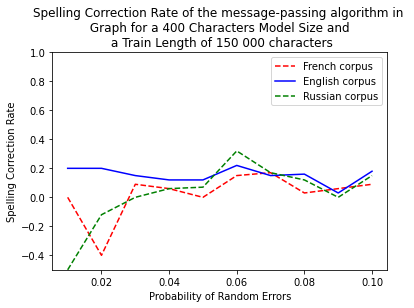

In [39]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
plt.title("Spelling Correction Rate of the message-passing algorithm in \n Graph for a 400 Characters Model Size and \n a Train Length of 150 000 characters")
plt.xlabel("Probability of Random Errors")
plt.ylabel("Spelling Correction Rate")
ax.set_ylim((-0.5,1))
ax.plot(typoProbs, french_spell_rate, '--r', label='French corpus')
ax.plot(typoProbs, english_spell_rate, '-b', label='English corpus')
ax.plot(typoProbs, russian_spell_rate, '--g', label='Russian corpus')
#ax.axis('equal')
leg = ax.legend();

English : 

*  Initial errors = 38, final errors = 34
*  alphabet size = 100;    time = 138.74571251869202



French :

*  Initial errors = 38, final errors = 34
*  alphabet size = 110;    time = 170.06994605064392;

German :

*  Initial errors = 45, final errors = 34
*  alphabet size = 88;    time = 107.42580819129944;

Spanich :

*  Initial errors = 50, final errors = 38
*  alphabet size = 98;    time = 133.53597831726074;

Italian :

*  Initial errors = 43, final errors = 40
*  alphabet size = 105;    time = 153.0992467403412;

Swedish :

*  Initial errors = 51, final errors = 42
*  alphabet size = 97;    time = 131.03797268867493;

Arabic :

*  Initial errors = 52, final errors = 48
*  alphabet size = 127;    time = 224.69961094856262

Russian :

*  Initial errors = 53, final errors = 43
*  alphabet size = 158;    time = 363.21314907073975;

# Other Try

Hyperparameters :
- Model Size is 30 characters
- typo probability is 0.01

In [ ]:
def run_experiment(method):
    time, energy = 0, 0
    nread = 0
    res = None
    
    full_names = ["English", "French", "German", "Spanish", "Italian", "Swedish" ,"Arabic", "Russian"]
    names = ["eng", "fra", "deu", "spa", "ita", "swe", "ara", "rus", "kor", "jpn"] 
    years = ["2005", "2005-2008", "2005", "2006", "2005-2009", "2007", "2005-2009", "2007", "2007", "2005-2008" ]
    encs = 'utf-8'

    skipchain = 1 

    trainlen = 100000 
    testlen = 30 
    nCorpora = 8 
    
    # Run text experiment for each language corpus
    for i in range(nCorpora):

      corpus = "/content/drive/MyDrive/Graphical models/data/New Text Corpus/{}_news_{}_100K-sentences.txt".format(names[i], years[i])


      perf, errs = 0, 0
      typoProb = 0.1
      
      print("   ***  {}  *** ".format(full_names[i]))

      N = alphabet_size(corpus, trainlen, testlen, encs)
      res, nread, time, perf = textprocess(method, corpus, trainlen, testlen, encs, time, nread, typoProb, skipchain, errs, perf, energy)

      print("alphabet size = {};    time = {};  multiplications = {};".format(N, time, nread))
      print()

      del corpus
      del res


In [ ]:
arg_method = METHOD.FAST

run_experiment(arg_method)

   ***  English  *** 
Graph created!
All messages transmitted!
Final belief message computed!
Initial errors = 4, final errors = 3, accuracy = 0.25
original ['I', ' ', 'd', 'i', 'd', 'n', "'", 't', ' ', 'k', 'n', 'o', 'w', ' ', 'i', 't', ' ', 'w', 'a', 's', ' ', 'p', 'o', 'l', 'i', 'c', 'e', ' ', '\x00']
test modified ['I', ' ', 'd', 'X', 'd', 'n', "'", '”', ' ', '1', 'n', 'o', 'w', ' ', 'i', 't', ' ', 'w', 'a', 's', ' ', 'p', 'o', 'l', 'i', 'c', '7', ' ', '\x00']
final result ['I', ' ', 'd', ' ', 'd', 'n', "'", 'e', ' ', 'a', 'n', 'o', 'w', ' ', 'i', 't', ' ', 'w', 'a', 's', ' ', 'p', 'o', 'l', 'i', 'c', 'e', ' ', '1', '1']
alphabet size = 100;    time = 4.834535121917725;  multiplications = 1132206;

   ***  French  *** 
Graph created!
All messages transmitted!
Final belief message computed!
Initial errors = 5, final errors = 2, accuracy = 0.6
original ['L', 'e', ' ', 't', 'r', 'i', 'b', 'u', 'n', 'a', 'l', ' ', 'd', 'e', ' ', 'c', 'o', 'm', 'm', 'e', 'r', 'c', 'e', ' ', 'd', 'e', ' 

English : 

*  Initial errors = 4, final errors = 3
*  alphabet size = 100;    time = 3.74



French :

*  Initial errors = 1, final errors = 0
*  alphabet size = 110;    time = 4.55;

'en imposer' noisé en '2n imposer' puis corrigé en 'en imposer'

German :

*  Initial errors = 6, final errors = 4
*  alphabet size = 88;    time = 2.975;

Spanich :

*  Initial errors = 2, final errors = 2
*  alphabet size = 98;    time = 3.66;

Italian :

*  Initial errors = 2, final errors = 2
*  alphabet size = 105;    time = 4.18;

Swedish :

*  Initial errors = 3, final errors = 4
*  alphabet size = 97;    time = 3.59;

Arabic :

*  Initial errors = 1, final errors = 0
*  alphabet size = 127;    time = 6.05;

Russian :

*  Initial errors = 0, final errors = 2
*  alphabet size = 158;    time = 9.82;

# To download other corpus, it's here :) 
https://wortschatz.uni-leipzig.de/en/download/English#eng_news_2016